# LCA with itemwise uncertainty 

Steps for Performing LCA with Itemwise Uncertainty:
1. Prepare the input files.
2. Import the product system.
3. Incorporate uncertainty information into the metadata.
4. Create datapackages with uncertainty information.
5. Perform the Life Cycle Assessment (LCA).

1. Navigate to the project that contains the ecoinvent database (ecoinvent database is not necessary if you don't need to find characterization factors through Brightway).

In [1]:
import bw2data as bd

bd.projects.set_current("advlca25")
bd.databases

/opt/anaconda3/envs/bw25/lib/python3.11/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


14:30:00+0100 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


Databases dictionary with 6 object(s):
	ALIGNED-biob-prod-dummy
	ALIGNED-biob-prod-dummy-alt
	cmc
	ecoinvent-3.11-biosphere
	ecoinvent-3.11-consequential
	testdb

2. Import required libraries

In [2]:
import os
from bamboo_lca.background_importer import *
from bamboo_lca.foreground_importer import *
from bamboo_lca.datapackage_builder import *
from bamboo_lca.uncertainty_handler import *
from bamboo_lca.lca_wrapper import *
from bamboo_lca.uncertainty_importer import *

/opt/anaconda3/envs/bw25/lib/python3.11/site-packages/bw2calc/__init__.py:56: UserWarning: scikit-umfpack found but couldn't be imported. Error: cannot import name 'Tester' from 'numpy.testing' (/opt/anaconda3/envs/bw25/lib/python3.11/site-packages/numpy/testing/__init__.py)
  warnings.warn(f"scikit-umfpack found but couldn't be imported. Error: {e}")


3. Define required constants

In [3]:
# BACKGROUND DATABASE FILE PATH
EXIOBASE_AGGREGATED_A_FILE = os.path.join(os.getcwd(), "data/A.txt")
EXIOBASE_AGGREGATED_S_FILE = os.path.join(os.getcwd(), "data/S.txt")

# FOREGROUND DATABASE FILE PATH
FOREGROUND_FILE = os.path.join(os.getcwd(), "data/uncertainty_file.csv")

# CHARACTERIZATION FACTOR MAPPING FILE PATH
CF_MAPPING_FILE = os.path.join(os.getcwd(), "data/cf_mapping_file.csv")

# LCIA METHOD
METHOD = ('ecoinvent-3.11', 'IPCC 2013', 'climate change', 'global temperature change potential (GTP100)')

# CHOSEN BIOSPHERE EMISSIONS
GHG = ["CO2 - combustion - air",
        "CO2 - non combustion - Cement production - air",
        "CO2 - non combustion - Lime production - air",
        "CO2 - waste - fossil - air",
        "CH4 - agriculture - air",
        "CH4 - waste - air",
        "CH4 - combustion - air",
        "CH4 - non combustion - Extraction/production of (natural) gas - air",
        "CH4 - non combustion - Extraction/production of crude oil - air",
        "CH4 - non combustion - Mining of antracite - air",
        "CH4 - non combustion - Mining of bituminous coal - air",
        "CH4 - non combustion - Mining of coking coal - air",
        "CH4 - non combustion - Mining of lignite (brown coal) - air",
        "CH4 - non combustion - Mining of sub-bituminous coal - air",
        "CH4 - non combustion - Oil refinery - air",
        "N2O - combustion - air",
        "N2O - agriculture - air",
        "SF6 - air"]

4. Import the background system. (Click [here](1.%20lca_with_background.ipynb) for more detailed explanation.)

In [4]:
bg_importer = BackgroundImporter()

tech_df = pd.read_table(EXIOBASE_AGGREGATED_A_FILE, sep='\t', header=None, low_memory=False)
raw_tech = tech_df.iloc[3:, 2:].astype('float').to_numpy()
tech_matrix = bg_importer.build_tech_matrix(raw_tech)

bio_df = pd.read_csv(EXIOBASE_AGGREGATED_S_FILE, header=[0,1], index_col=[0], sep='\t', low_memory=False)
bio_matrix = bg_importer.build_bio_matrix(bio_df, GHG)

cf_matrix = bg_importer.build_cf_matrix(CF_MAPPING_FILE, GHG)

All characterization factors have been found.


5. Import the foregorund system. (Click [here](2.%20lca_with_foreground.ipynb) for more detailed explanation.)

In [5]:
# Find all activities in the product system.
bg_activities = get_bg_activities(EXIOBASE_AGGREGATED_A_FILE, "\t")
fg_activities = get_fg_activities(FOREGROUND_FILE, ",", bg_activities)
activities = fg_activities + bg_activities

# Import the foreground system
fg_tech_df = pd.read_table(FOREGROUND_FILE, sep=',')
fg_dataframe = get_fg_dataframe(fg_tech_df, fg_activities)

fg_importer = ForegroundImporter()
fgbg, fgfg, bgfg, bifg = fg_importer.extend_matrix(fg_dataframe, GHG, fg_activities, bg_activities)
full_tech_matrix, full_bio_matrix = fg_importer.concatenate_matrix(tech_matrix, bio_matrix, fgbg, fgfg, bgfg, bifg)

6. Prepare datapackage matrix data

In [6]:
dp_builder = DatapackageBuilder()

(tech_data, tech_indices, tech_flip), (bio_data, bio_indices), (cf_data, cf_indices) = dp_builder.prepare_dp_matrix(full_tech_matrix, full_bio_matrix, cf_matrix)
datapackage_data = (tech_data, tech_indices, tech_flip), (bio_data, bio_indices), (cf_data, cf_indices)

7. Add uncertainty into metadata

In [7]:
uncertainty_importer = UncertaintyImporter(FOREGROUND_FILE, ",")
uncertainty_importer.update_metadata_uncertainty(activities, "itemwise")
uncertainty_importer.metadata

/opt/anaconda3/envs/bw25/lib/python3.11/site-packages/bamboo_lca/uncertainty_importer.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  negative_list = selected_df_2["Exchange negative"].replace(0, False).astype(bool).fillna(False).tolist()


{0: {'Activity name': 'column_3',
  'Activity uncertainty type': 2,
  'Exchange uncertainty amount': [1.111,
   2.674794737,
   2.674794737,
   0.0,
   0.0,
   0.0,
   3.33000452,
   1.54,
   1.54,
   0.0,
   1.54,
   1.54,
   4.09770687,
   0.0,
   1.59,
   0.0,
   0.0,
   2.014014413,
   0.0,
   2.674794737,
   2.674794737,
   2.674794737,
   2.674794737,
   2.674794737,
   2.674794737,
   2.674794737,
   2.674794737,
   0.0,
   2.674794737,
   2.674794737,
   0.0,
   2.674794737,
   2.288684673,
   0.0,
   0.0,
   0.0,
   2.238117654,
   2.699910682,
   0.0,
   1.56,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  'Exchange negative': [False,
   True,
   True,
   True,
   True,
   True,
   False,
   True,
   True,
   Tru

8. Prepare datapackage uncertainty data

In [8]:
uncertainty_handler = UncertaintyHandler()
tech_uncertainty_array = uncertainty_handler.add_nonuniform_uncertainty(tech_data, tech_indices, "itemwise", fg_num=2, fg_strategy="itemwise")
bio_uncertainty_array = uncertainty_handler.add_nonuniform_uncertainty(bio_data, bio_indices, "itemwise", fg_num=2, fg_strategy="itemwise")
uncertainty = [tech_uncertainty_array, bio_uncertainty_array, None]

8. Create the datapackage

In [9]:
dp = dp_builder.prepare_datapackage(datapackage_data, uncertainty)

9. Set functional unit

In [10]:
# Set "RoW-Services" as functional unit.
# NOTE: By default, the region and industry name are joined with a dash.
selected_activity = "RoW-Services"

# Find the index of the activity in activities.
index = activities.index(selected_activity)

# Define the functional unit
functional_unit = {index: 1}
print(f"The functional unit is {functional_unit}")

The functional unit is {71: 1}


10. Perform LCA

In [11]:
lca = bc.LCA(
            demand=functional_unit,
            data_objs=[dp],
            use_distributions=True,
        )
lca.lci()
lca.lcia()

print(f"Brightway calculated lca score: {activities[index]}, {lca.score}")

Brightway calculated lca score: RoW-Services, 291151.38059559744


11. Perform 100 Monte Carlo simulations to analyze the uncertainty and check the `lca.score` distribution.

,0
count,100.000000
mean,291156.892500
std,7.317709
min,291149.173597
25%,291151.726271
50%,291154.841274
75%,291160.069815
max,291191.026833


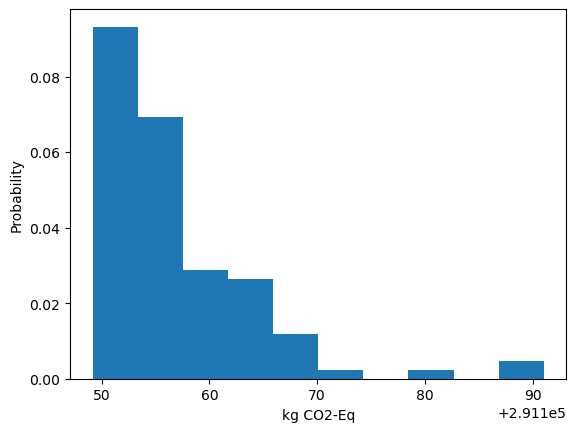

In [12]:
from matplotlib import pyplot as plt

mc_results = [lca.score for _ in zip(range(100), lca)]
plt.hist(mc_results, density=True)
plt.ylabel("Probability")
plt.xlabel(bd.methods[METHOD]["unit"])
pd.DataFrame(mc_results).describe()